In [3]:
!pip install pdfplumber
!pip install PyPDF2 pdf2image
!apt-get install poppler-utils
!pip install fitz
!pip install PyMuPDF
!pip install keybert
!pip install textsum
!pip install spacy

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached keybert-0.8.3.tar.gz (29 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached rich-13.6.0-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
  Using cached transformers-4.34.0-py3-none-any.whl.metadata (121 kB)
  Usin

In [2]:
import spacy
import fitz  # PyMuPDF
import os
import re
import pandas as pd
from PyPDF2 import PdfReader
from pdf2image import convert_from_path
import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
from textsum.summarize import Summarizer
from keybert import KeyBERT
import os
os.environ['PATH'] += ':/usr/local/bin'

ModuleNotFoundError: No module named 'spacy'

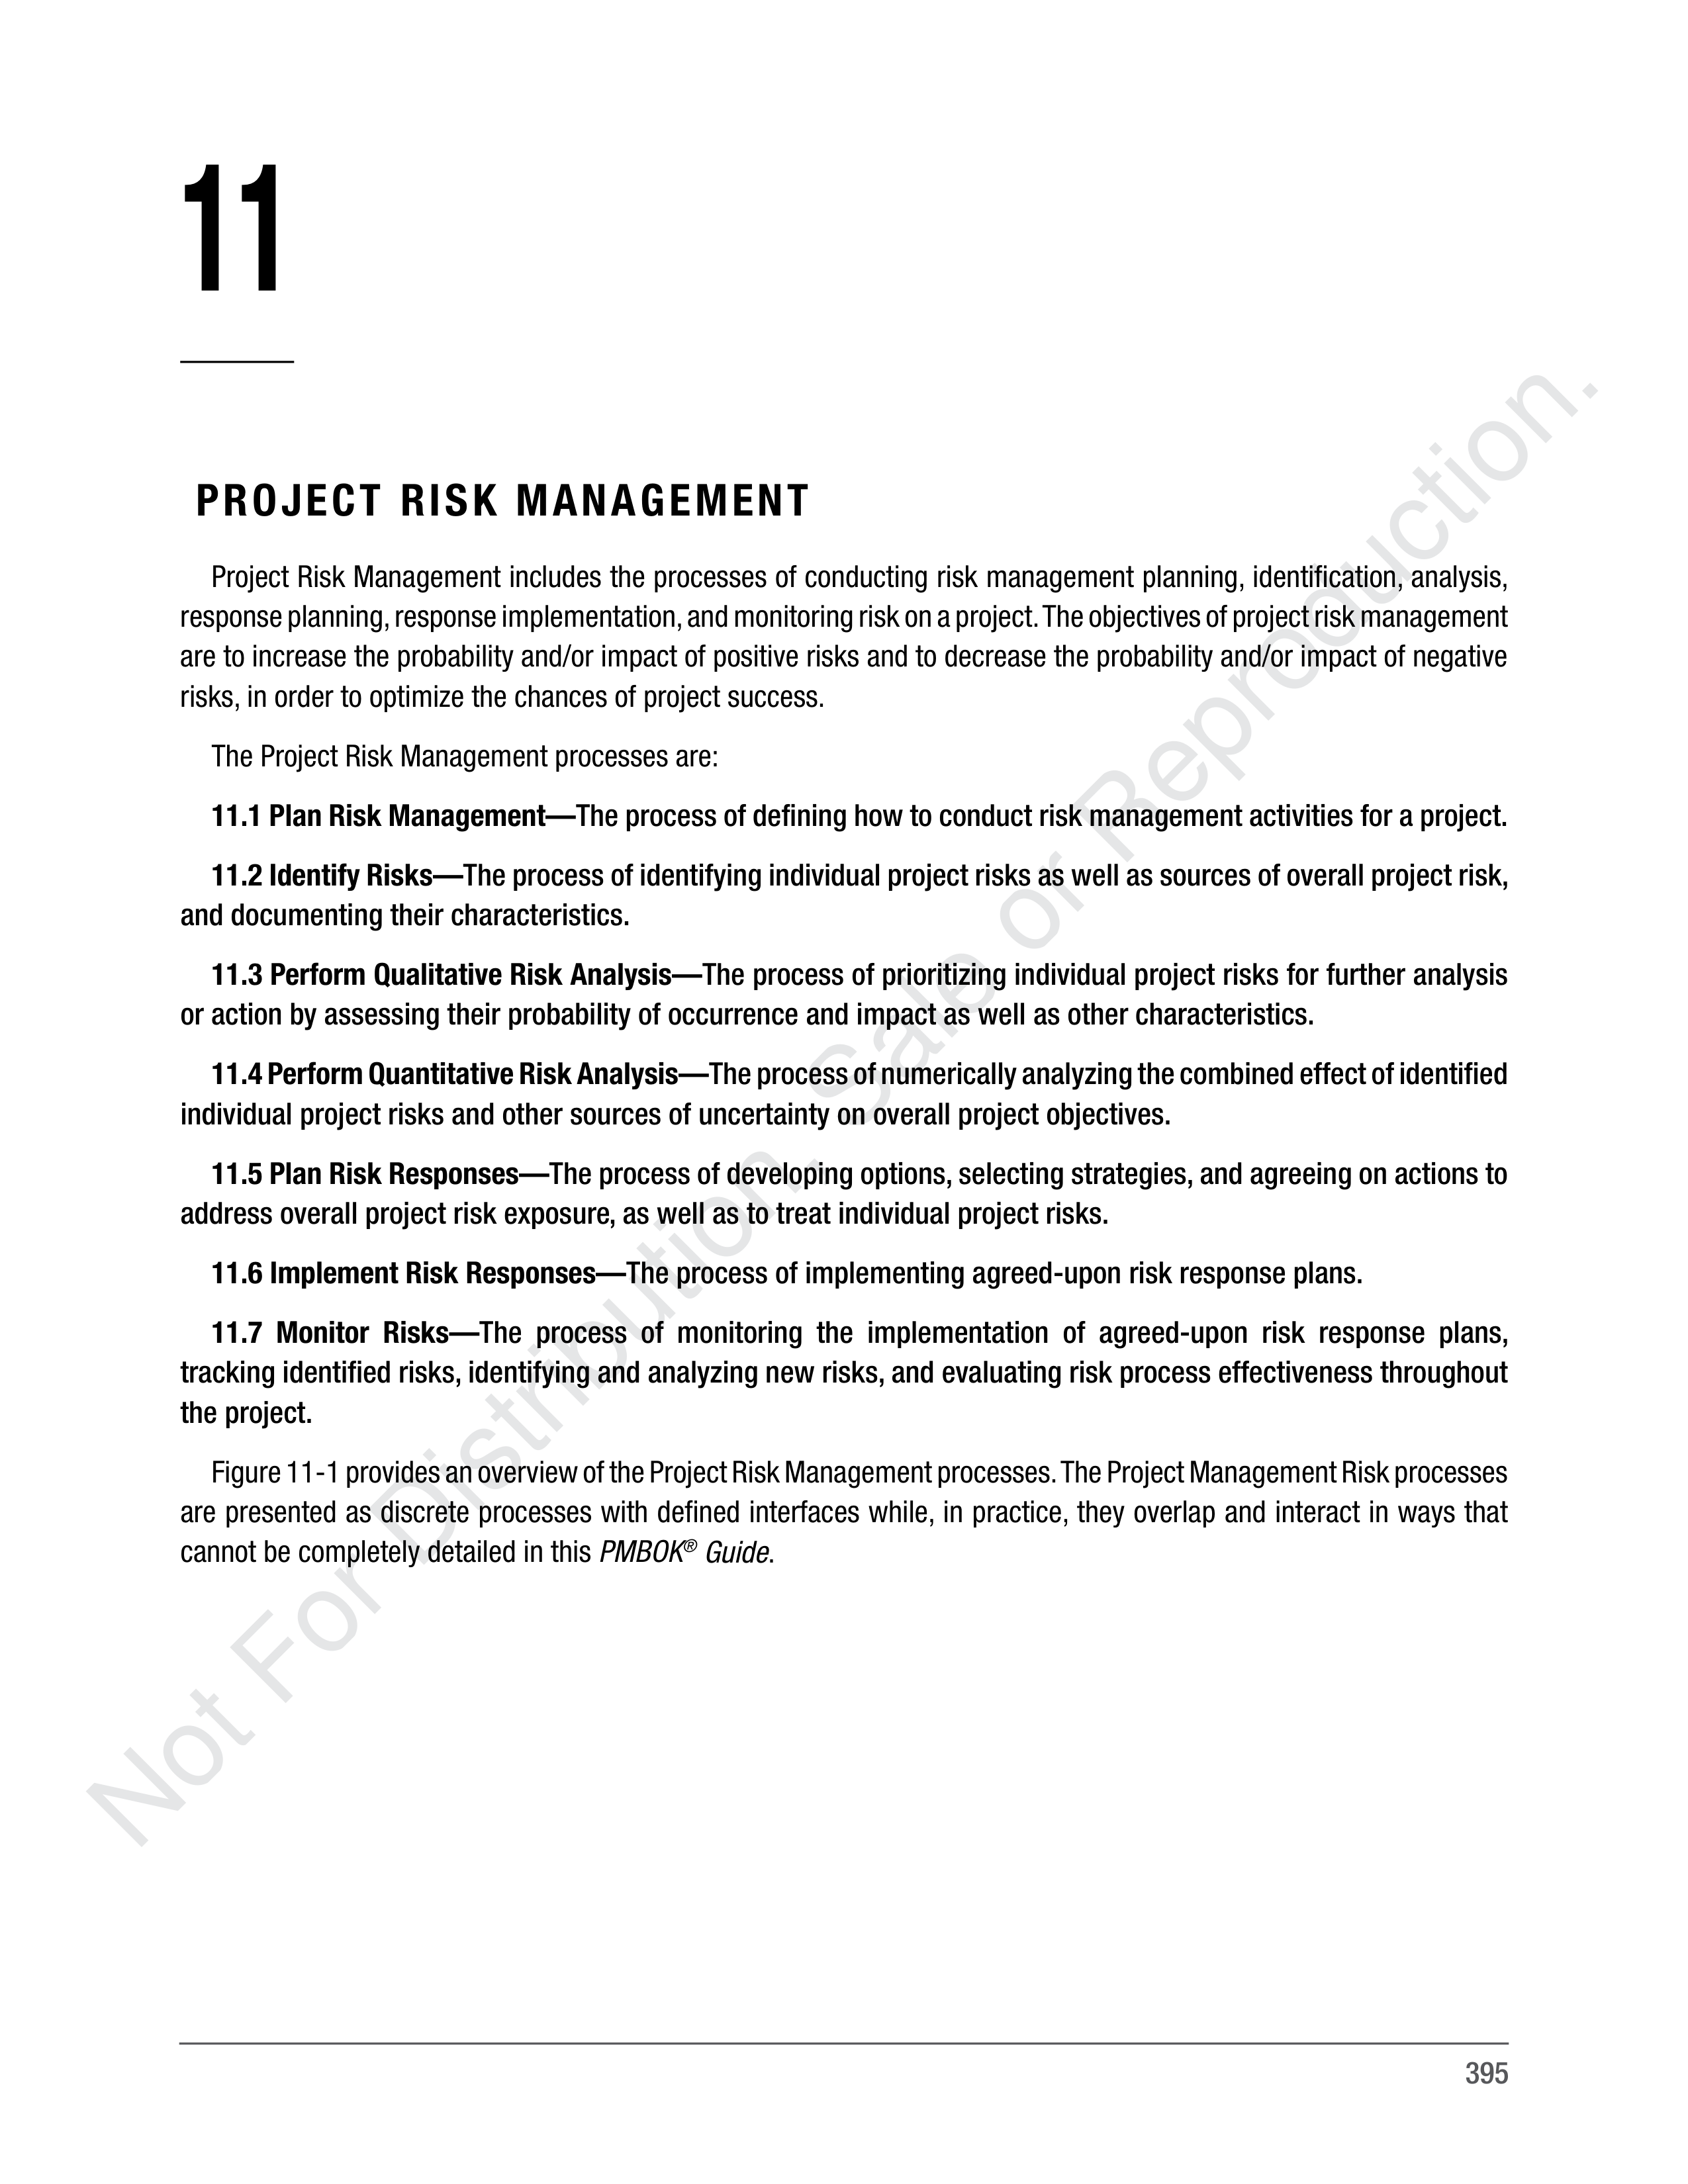

In [ ]:

# Specify the file name of your uploaded PDF
pdf_file_path = 'pmbok.pdf'

# Create a folder to save the extracted data and images
os.makedirs('captures', exist_ok=True)

# Initialize variables to store data
data = []
current_section = None
current_title = None
current_text = []
current_urls = []

# Function to capture and save images from a specific region
def capture_and_save_images(page, page_num, bbox):
    images = convert_from_path(pdf_file_path, first_page=page_num + 1, last_page=page_num + 1)
    for i, image in enumerate(images):
        image_path = f'captures/page_{page_num + 1}_image_{i + 1}.png'
        image.save(image_path, 'PNG')
        current_urls.append(image_path)

# Define a minimum area threshold to filter small contours
min_area_threshold = 11000

# Initialize variables to store URLs
url_counter = 0  # Initialize a counter for URLs


# Open the PDF document
pdf_document = fitz.open(pdf_file_path)

# Loop through the pages of the PDF
for page_num in range(len(pdf_document)):
    page = pdf_document[page_num]
    text = page.get_text()
    page_image = page.get_pixmap(matrix=fitz.Matrix(300 / 72, 300 / 72))

    text_lines = text.split('\n')
    image_path = f'captures/page_{page_num + 1}.png'
    page_image.save(image_path, 'PNG')

    # Load an image
    image = cv2.imread(image_path)
    os.remove(image_path)

    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform edge detection using Canny
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image for drawing bounding boxes
    image_with_boxes = image.copy()

    # Initialize variables to store information about the largest ROIs
    largest_rois = []

    # Iterate through detected contours
    for i, contour in enumerate(contours):
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        if area > min_area_threshold:
            # Get the bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)

            # Crop the region of interest (ROI)
            roi = image[y:y+h, x:x+w]

            # Draw a bounding box around the detected region
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Append the ROI to the list of largest ROIs
            largest_rois.append(roi)

            # Save the ROI with an associated URL
            if url_counter < len(current_urls):
                original_url = current_urls[url_counter]
                cv2.imwrite(original_url, roi)
                url_counter += 1  # Increment the URL counter

    # Display the image with bounding boxes
    cv2_imshow(image_with_boxes)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Capture and save the images of the largest ROIs
    for i, roi in enumerate(largest_rois):
        roi_image_path = f'captures/page_{page_num + 1}_image_{i + 1}.png'
        cv2.imwrite(roi_image_path, roi)
        current_urls.append(roi_image_path)

    # Process the text in the same way you were doing
    for line in text_lines:
        # Check if the line matches the section format
        match = re.match(r'^(\d+(\.\d+)+) ([A-Z][A-Z\s]+)', line)

        if match:
            # Save the previous section data if available
            if current_section:
                data.append({
                    'Index': current_section[0],
                    'Concepts': current_title,
                    'Text': '\n'.join(current_text),  # Combine text lines into one line
                    'Refrences': ' ,\n'.join(current_urls)  # Join multiple URLs with a comma
                })

            # Initialize data for the new section
            current_section = (match.group(1), match.group(2))
            current_title = match.group(3)
            current_text = []
            current_urls = []
        else:
            # Check if the line contains "Tableau" or "Figure"
            if "Table" in line or "Figure" in line:internship
                # Capture and save the image (specify the region where the image is located)
                pass
            else:
                current_text.append(line)

# Save the last section data
if current_section:
    data.append({
        'Index': current_section[0],
        'Concepts': current_title,
        'Text': ' '.join(current_text),  # Combine text lines into one line
        'Refrences': ' ,\n'.join(current_urls)  # Join multiple URLs with a comma
    })

# Create a DataFrame from the extracted data
df = pd.DataFrame(data)


In [ ]:
df['Text'] = df['Text'].str.replace(r'Not For Distribution, Sale or Reproduction\.\s?(?:\d+.*?(?=\s\w)|\s\w.*)', '', regex=True)
df['Text'] = df['Text'].str.replace(r'\bu\s+u\b', '', regex=True)

# References

ModuleNotFoundError: ignored

# Definition

In [ ]:
model_name = "pszemraj/led-q-book-summary"
summarizer = Summarizer(
    model_name_or_path=model_name,  # you can use any Seq2Seq model on the Hub
    token_batch_length=4096,  # how many tokens to batch summarize at a time
  )
def text_summarizer(text):
  long_string = text
  out_str = summarizer.summarize_string(long_string)
  return out_str

df['Definition']= df['Text'].apply(text_summarizer)
print(df)

In [ ]:
df

# Keywords

In [ ]:
def extract_keywords_with_keybert(text):
    text_length = len(text.split())
    top = int(text_length * 0.2)
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', use_mmr=True, top_n=top, diversity=0.9)
    keywords = [kw[0] for kw in keywords]
    return keywords

df['Keywords'] = df['Text'].apply(extract_keywords_with_keybert)
df

,Index,Title,Text,URLs,Concepts,Refrences,Definition,Keywords
0,11.1,PLAN RISK MANAGEMENT,Plan Risk Management is the process of deﬁning...,captures/page_8_image_1.png,NaN,NaN,"we'll delve deeper into the ""plan risk managem...","[risk management, management process, plan com..."
1,11.1.1,PLAN RISK MANAGEMENT,,,NaN,NaN,The Secret History of the Underground Railroad,[]
2,11.1.1.1,PROJECT CHARTER,Described in Section 4.1.3.1. The project char...,,NaN,NaN,The High-Level Project Charter documents and d...,"[project charter, risks, documents high]"
3,11.1.1.2,PROJECT MANAGEMENT PLAN,Described in Section 4.2.3.1. In planning Proj...,,NaN,NaN,This section sets out the methodology that is ...,"[project risk, subsidiary management, plan con..."
4,11.1.1.3,PROJECT DOCUMENTS,Project documents that can be considered as in...,,NaN,NaN,This paper provides detailed information about...,"[stakeholder register, project setting, docume..."
...,...,...,...,...,...,...,...,...
105,11.7.3.1,WORK PERFORMANCE INFORMATION,Described in Section 4.5.1.3. Work performance...,,NaN,NaN,This section provides additional information r...,"[work performance, information project, risks ..."
106,11.7.3.2,CHANGE REQUESTS,Described in Section 4.3.3.4. The Monitor Risk...,,NaN,NaN,A change request from the Monitor Risks Proces...,"[risks process, project management, monitor, r..."
107,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,Any change to the project management plan goes...,,NaN,NaN,A change request is made that changes the orga...,"[change project, plan guide, request affect, c..."
108,11.7.3.4,PROJECT DOCUMENTS UPDATES,Project documents that may be updated as a res...,,NaN,NaN,Affected Project documents include the Assumpt...,"[risk register, project documents, effectivene..."


# Synonym

In [ ]:
nlp = spacy.load('en_core_web_sm')
text_series = df['Text']
docs = [nlp(text) for text in text_series]
pos_tags = [token.pos_ for token in docs[-1]]


In [ ]:
docs

In [ ]:
pos_= [token.pos_ for token in docs[0]]
pos_

In [ ]:
# Iterate over tokens in the 'docs' object and print POS tags and their explanations
for doc in docs:
    for word in doc:
      print(word.text,"------>", word.pos_,word.tag_,spacy.explain(word.tag_))

In [ ]:
from spacy import displacy
displacy.render(docs,style='dep',jupyter=True)

In [ ]:
options={
    'distance':80,
    'compact':True,
    'color':'#fff',
    'bg':'#00a65a'
}
displacy.render(docs,style='dep',jupyter=True,options=options)

In [ ]:
from nltk.corpus import wordnet as wn
from nltk import wsd
# Assuming your DataFrame has a 'Text' column
title_series = df['Title']  # Replace 'Text' with the actual column name

# Process each text in the Series
doc = [nlp(text) for text in title_series]

In [ ]:
doc

In [ ]:
import nltk
nltk.download("wordnet")
for doc in docs:
    for token in doc:
        synsets = wn.synsets(token.text)
        if synsets:
            print(f"Token: {token.text}")
            for synset in synsets:
                print(f" - Synset: {synset.name()}, Synonym: {synset.definition()}")

In [ ]:
# Initialize empty lists to store data
tokens_list = []
synsets_list = []
Synonym_list = []

# Loop through the documents and tokens to collect data
for doc in docs:
    for token in doc:
        synsets = wn.synsets(token.text)
        if synsets:
            for synset in synsets:
                # Append token, synset, and Synonym to lists
                tokens_list.append(token.text)
                synsets_list.append(synset.name())
                Synonym_list.append(synset.definition())

# Create a pandas DataFrame with the collected data
data = {
    "Token": tokens_list,
    "Synset": synsets_list,
    "Synonym": Synonym_list,
}
df_syn = pd.DataFrame(data)
df_syn

In [ ]:
def get_synonyms(token):
    synsets = wn.synsets(token.text)
    synonyms = []
    for synset in synsets:
        synonyms.extend(synset.lemma_names())
    synonyms = list(set(synonyms))
    return synonyms

# Create a list to store token-synonyms pairs
token_synonyms_data = []

# Iterate over tokens in the 'docs' object and generate synonyms for nouns and verbs
for doc in docs:
    for token in doc:
        if token.pos_ in ("NOUN", "VERB"):
            synonyms = get_synonyms(token)
            token_synonyms_data.append((token.text, synonyms))

# Create a DataFrame from the list
df_synn = pd.DataFrame(token_synonyms_data, columns=["Token", "Synonyms"])

df_synn

# Text Auxiliaire